## Importación de las librerías

In [2]:
import tensorflow as tf
import itertools
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, callbacks
from tensorflow import argmax
from tensorflow import expand_dims
from matplotlib import pyplot as plt
from keras import utils
import matplotlib.pyplot as plt
import os 
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Tratamiento del datset

In [3]:
#Usamos la técnica de Data Augmentation para mejorar el dataset.
gen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255)

#Cargamos los datos de train y test redimensionándolos, cambiándoles la escala de color y variando el batch
#y se especifica el tipo de dataset

train_iter = gen.flow_from_directory('Covid19-dataset/train',target_size = (200, 200),
                                       batch_size = 16,color_mode = 'rgb', class_mode='categorical')

test_iter = gen.flow_from_directory('Covid19-dataset/test',target_size = (200, 200),
                                       batch_size = 16,color_mode = 'rgb', class_mode='categorical')

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


## Muestra de las 3 categorías del dataset

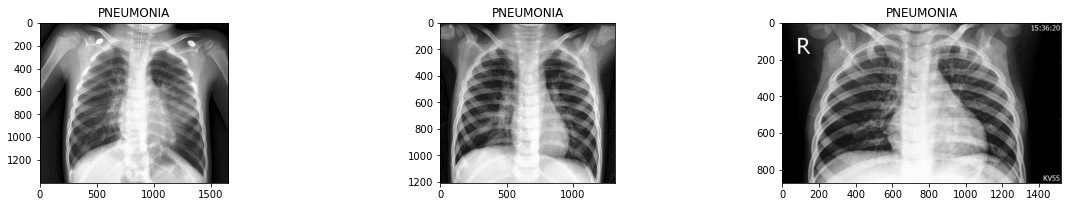

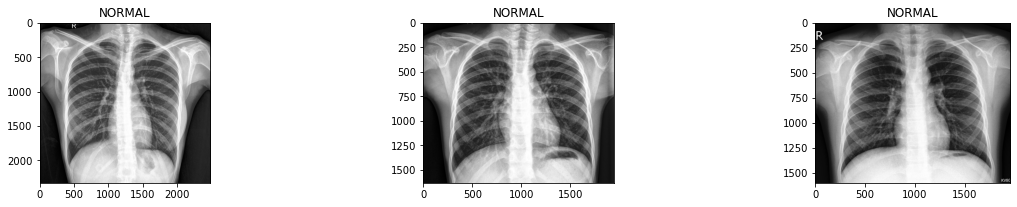

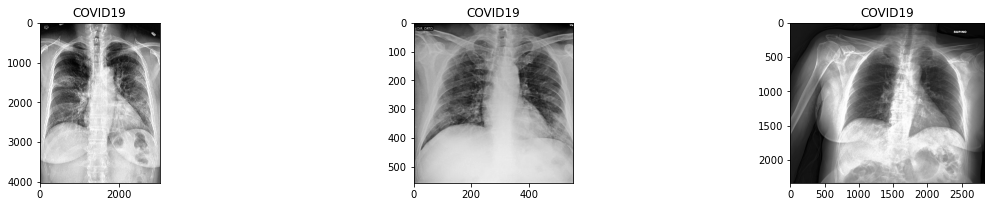

In [4]:
#Se muestran los distintos tipos de imagenes
train_image='Covid19-dataset/train'
pneumonia_images = os.listdir(train_image + "/Pneumonia")
normal_images = os.listdir(train_image + "/Normal")
covid_images = os.listdir(train_image + "/Covid")
#se muestran las imágenes de etiqueta PNEUMONIA
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_image + "/Pneumonia",pneumonia_images[i])),cmap='gray')
    plt.title("PNEUMONIA")
    
plt.show()
#se muestran las imágenes de  etiqueta NORMAL
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_image + "/Normal",normal_images[i])),cmap='gray')
    plt.title("NORMAL")

plt.show()
#se muestran las imágenes de etiqueta COVID
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(train_image + "/Covid",covid_images[i])),cmap='gray')
    plt.title("COVID19")

## Generación de las redes neuronales haciendo uso del Transfern Learning

In [5]:
#generamos la red neuronal, haciendo el uso del transfern learning, con la VGG16
VGG16_model = VGG16(input_shape = train_iter.image_shape,
                    include_top = False, weights = 'imagenet')
VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [6]:
#Congelamos las capas de base convolucional con el fin de evitar que sus pesos sean actualizados
#durante el entrenamiento
for i in VGG16_model.layers:
    layers.trainable = False


In [7]:
#generamos la red neuronal, haciendo el uso del transfern learning, con la VGG19
VGG19_model = VGG19(input_shape = train_iter.image_shape,
                    include_top = False, weights = 'imagenet')
VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [8]:
#Congelamos las capas de base convolucional con el fin de evitar que sus pesos sean actualizados
#durante el entrenamiento
for i in VGG19_model.layers:
    layers.trainable = False


In [9]:
#generamos la red neuronal, haciendo el uso del transfern learning, con la Xception
xception_model = Xception(input_shape = train_iter.image_shape,
                    include_top = False, weights = 'imagenet')
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [10]:
#Congelamos las capas de base convolucional con el fin de evitar que sus pesos sean actualizados
#durante el entrenamiento
for i in xception_model.layers:
    layers.trainable = False

In [11]:
#Ahora creamos nuestro modelo con VGG16
tfVGG16_model = keras.Sequential([
    VGG16_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation = 'softmax'),
])
tfVGG16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 17,074,499
Trainable params: 17,074,499
Non-trainable params: 0
_________________________________________________________________


In [12]:
#Ahora creamos nuestro modelo con VGG19
tfVGG19_model = keras.Sequential([
    VGG19_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation = 'softmax'),
])
tfVGG19_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2359424   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 22,384,195
Trainable params: 22,384,195
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Ahora creamos nuestro modelo con xception
tfXception_model = keras.Sequential([
    xception_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation = 'softmax'),
])
tfXception_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               12845184  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 33,707,051
Trainable params: 33,652,523
Non-trainable params: 54,528
_________________________________________________________________


## Generación de la red neuronal creada desde cero

In [64]:
#Ahora creamos nuestro modelo propio
final_model = keras.Sequential([
    layers.Input(shape = train_iter.image_shape),
    layers.Conv2D(64, 3,padding = "same",  activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3,padding = "same",  activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation = 'softmax'),
])
final_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 200, 200, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               20480128  
_________________________________________________________________
dense_18 (Dense)             (None, 3)                

## Compilación y entrenamiento de los modelos

In [65]:
#Ahora compilamos las redes neuronales creadas 
tfXception_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
final_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
tfVGG16_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
tfVGG19_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])


In [66]:
#Se crea el early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=2, 
    restore_best_weights=True,
)

In [67]:
#Entrenamos nuestras redes neuronales
history_final = final_model.fit(train_iter, epochs = 10,batch_size = 16,callbacks=[early_stopping],
                         validation_data=test_iter)

Epoch 1/10
16/16 [==============================] - 18s 1s/step - loss: 2.7561 - accuracy: 0.4085 - val_loss: 1.0138 - val_accuracy: 0.5303
Epoch 2/10
16/16 [==============================] - 20s 1s/step - loss: 0.8724 - accuracy: 0.5887 - val_loss: 0.9757 - val_accuracy: 0.5455
Epoch 3/10
16/16 [==============================] - 18s 1s/step - loss: 0.7090 - accuracy: 0.6560 - val_loss: 0.7999 - val_accuracy: 0.6061
Epoch 4/10
16/16 [==============================] - 18s 1s/step - loss: 0.5502 - accuracy: 0.7910 - val_loss: 0.8475 - val_accuracy: 0.6212
Epoch 5/10
16/16 [==============================] - 17s 1s/step - loss: 0.5960 - accuracy: 0.7078 - val_loss: 0.7432 - val_accuracy: 0.6061
Epoch 6/10
16/16 [==============================] - 18s 1s/step - loss: 0.6174 - accuracy: 0.7083 - val_loss: 0.6336 - val_accuracy: 0.7273
Epoch 7/10
16/16 [==============================] - 17s 1s/step - loss: 0.4478 - accuracy: 0.8403 - val_loss: 0.5723 - val_accuracy: 0.7879
Epoch 8/10
16/16 [==

In [16]:
history_VGG16 = tfVGG16_model.fit(train_iter, epochs = 10,batch_size = 16,callbacks=[early_stopping],
                         validation_data=test_iter)

Epoch 1/10
16/16 [==============================] - 64s 4s/step - loss: 3.2014 - accuracy: 0.3163 - val_loss: 2.9502 - val_accuracy: 0.3030
Epoch 2/10
16/16 [==============================] - 62s 4s/step - loss: 1.7019 - accuracy: 0.3046 - val_loss: 1.1080 - val_accuracy: 0.2879
Epoch 3/10
16/16 [==============================] - 67s 4s/step - loss: 1.1034 - accuracy: 0.4035 - val_loss: 1.0789 - val_accuracy: 0.3939
Epoch 4/10
16/16 [==============================] - 67s 4s/step - loss: 0.9835 - accuracy: 0.5133 - val_loss: 0.9480 - val_accuracy: 0.6667
Epoch 5/10
16/16 [==============================] - 67s 4s/step - loss: 1.0494 - accuracy: 0.5139 - val_loss: 1.0106 - val_accuracy: 0.3939
Epoch 6/10
16/16 [==============================] - 73s 5s/step - loss: 0.9661 - accuracy: 0.4455 - val_loss: 1.0440 - val_accuracy: 0.4394
Epoch 7/10
16/16 [==============================] - 70s 4s/step - loss: 0.9131 - accuracy: 0.5453 - val_loss: 0.9901 - val_accuracy: 0.5303
Epoch 8/10
16/16 [==

In [24]:
history_VGG19 = tfVGG19_model.fit(train_iter, epochs = 10,batch_size = 16,callbacks=[early_stopping],
                         validation_data=test_iter)

Epoch 1/10
16/16 [==============================] - 79s 5s/step - loss: 12.1028 - accuracy: 0.3822 - val_loss: 1.0976 - val_accuracy: 0.3939
Epoch 2/10
16/16 [==============================] - 114s 7s/step - loss: 1.0945 - accuracy: 0.4542 - val_loss: 1.1024 - val_accuracy: 0.3939
Epoch 3/10
16/16 [==============================] - 101s 6s/step - loss: 1.0769 - accuracy: 0.4535 - val_loss: 1.0831 - val_accuracy: 0.3939
Epoch 4/10
16/16 [==============================] - 106s 7s/step - loss: 1.0597 - accuracy: 0.4390 - val_loss: 1.1378 - val_accuracy: 0.3939
Epoch 5/10
16/16 [==============================] - 106s 7s/step - loss: 1.0719 - accuracy: 0.4197 - val_loss: 1.0917 - val_accuracy: 0.3939


In [29]:
history_Xception = tfXception_model.fit(train_iter, epochs = 10,batch_size = 16,callbacks=[early_stopping],
                         validation_data=test_iter)

Epoch 1/10
16/16 [==============================] - 54s 3s/step - loss: 0.8453 - accuracy: 0.5139 - val_loss: 1.8860 - val_accuracy: 0.5000
Epoch 2/10
16/16 [==============================] - 59s 4s/step - loss: 0.6611 - accuracy: 0.6454 - val_loss: 1.0127 - val_accuracy: 0.4242
Epoch 3/10
16/16 [==============================] - 58s 4s/step - loss: 0.7231 - accuracy: 0.6295 - val_loss: 5.2643 - val_accuracy: 0.4242
Epoch 4/10
16/16 [==============================] - 59s 4s/step - loss: 0.6349 - accuracy: 0.7570 - val_loss: 0.5233 - val_accuracy: 0.7879
Epoch 5/10
16/16 [==============================] - 69s 4s/step - loss: 0.5932 - accuracy: 0.7052 - val_loss: 0.8069 - val_accuracy: 0.6364
Epoch 6/10
16/16 [==============================] - 65s 4s/step - loss: 0.3575 - accuracy: 0.8446 - val_loss: 0.5502 - val_accuracy: 0.8182


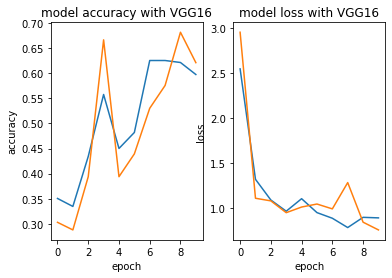

In [18]:
#Obtenemos una tabla donde poder comparar el accuracy real del esperado y la pérdida real y la esperada del modelo con VGG16
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16.history['val_accuracy'])
plt.title('model accuracy with VGG16')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.sca(axarr[1]); 
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.title('model loss with VGG16')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

              precision    recall  f1-score   support

           0       0.42      0.50      0.46        26
           1       0.00      0.00      0.00        20
           2       0.31      0.50      0.38        20

    accuracy                           0.35        66
   macro avg       0.24      0.33      0.28        66
weighted avg       0.26      0.35      0.30        66

[[13  3 10]
 [ 8  0 12]
 [10  0 10]]


<AxesSubplot:>

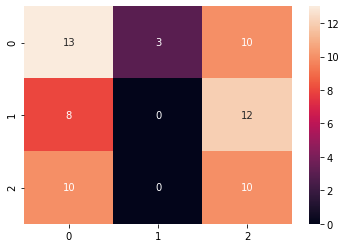

In [22]:
#Matriz de confusiónc para el modelo con VGG16
predictions1 = np.argmax(tfVGG16_model.predict(test_iter), axis = -1)
predictions1
cl_report1=classification_report(test_iter.classes, predictions1)
print(cl_report1)
print(confusion_matrix(test_iter.classes,predictions1))
sns.heatmap(confusion_matrix(test_iter.classes,predictions1), annot = True)

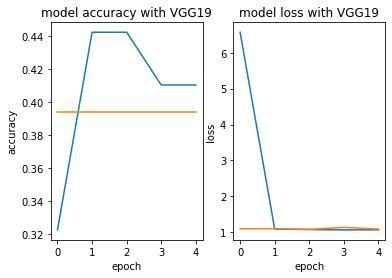

In [26]:
#Obtenemos una tabla donde poder comparar el accuracy real del esperado y la pérdida real y la esperada del modelo con VGG19
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history_VGG19.history['accuracy'])
plt.plot(history_VGG19.history['val_accuracy'])
plt.title('model accuracy with VGG19')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.sca(axarr[1]); 
plt.plot(history_VGG19.history['loss'])
plt.plot(history_VGG19.history['val_loss'])
plt.title('model loss with VGG19')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

              precision    recall  f1-score   support

           0       0.39      1.00      0.57        26
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        20

    accuracy                           0.39        66
   macro avg       0.13      0.33      0.19        66
weighted avg       0.16      0.39      0.22        66

[[26  0  0]
 [20  0  0]
 [20  0  0]]


/Users/nano/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nano/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nano/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

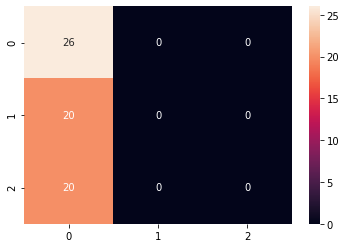

In [27]:
#Matriz de confusiónc para el modelo con VGG19
predictions2 = np.argmax(tfVGG19_model.predict(test_iter), axis = -1)
predictions2
cl_report2=classification_report(test_iter.classes,predictions2)
print(cl_report2)
print(confusion_matrix(test_iter.classes,predictions2))
sns.heatmap(confusion_matrix(test_iter.classes,predictions2), annot = True)

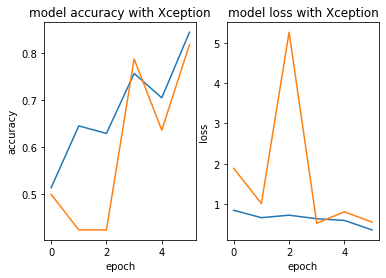

In [68]:
#Obtenemos una tabla donde poder comparar el accuracy real del esperado y la pérdida real y la esperada del modelo con Xception
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history_Xception.history['accuracy'])
plt.plot(history_Xception.history['val_accuracy'])
plt.title('model accuracy with Xception')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.sca(axarr[1]); 
plt.plot(history_Xception.history['loss'])
plt.plot(history_Xception.history['val_loss'])
plt.title('model loss with Xception')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

              precision    recall  f1-score   support

           0       0.28      0.27      0.27        26
           1       0.25      0.25      0.25        20
           2       0.00      0.00      0.00        20

    accuracy                           0.18        66
   macro avg       0.18      0.17      0.17        66
weighted avg       0.19      0.18      0.18        66

[[ 7  6 13]
 [ 7  5  8]
 [11  9  0]]


<AxesSubplot:>

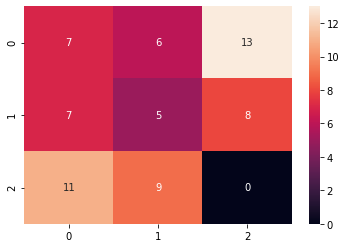

In [32]:
#Matriz de confusión para el modelo con Xception
predictions3 = np.argmax(tfXception_model.predict(test_iter), axis = -1)
predictions3
cl_report3=classification_report(test_iter.classes,predictions3)
print(cl_report3)
print(confusion_matrix(test_iter.classes,predictions3))
sns.heatmap(confusion_matrix(test_iter.classes,predictions3), annot = True)

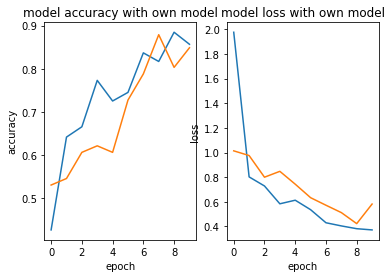

In [69]:
#Obtenemos una tabla donde poder comparar el accuracy real del esperado y la pérdida real y la esperada del modelo desde cero
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy with own model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.sca(axarr[1]); 
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss with own model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

              precision    recall  f1-score   support

           0       0.37      0.42      0.39        26
           1       0.30      0.35      0.33        20
           2       0.15      0.10      0.12        20

    accuracy                           0.30        66
   macro avg       0.27      0.29      0.28        66
weighted avg       0.28      0.30      0.29        66

[[11  7  8]
 [10  7  3]
 [ 9  9  2]]


<AxesSubplot:>

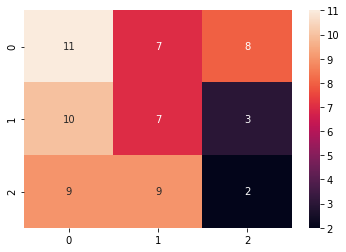

In [70]:
#Matriz de confusión para el modelo creado desde cero
predictions4 = np.argmax(final_model.predict(test_iter), axis = -1)
predictions4
cl_report4=classification_report(test_iter.classes,predictions4)
print(cl_report4)
print(confusion_matrix(test_iter.classes,predictions4))
sns.heatmap(confusion_matrix(test_iter.classes,predictions4), annot = True)

X_ray0
	Model prediction: [0.0056553  0.09058045 0.90376425]
	True label: Pneumonia (2)
	Correct: True


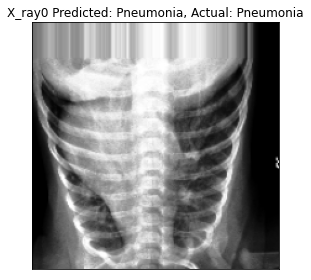

X_ray1
	Model prediction: [8.4632833e-04 3.4920520e-03 9.9566156e-01]
	True label: Pneumonia (2)
	Correct: True


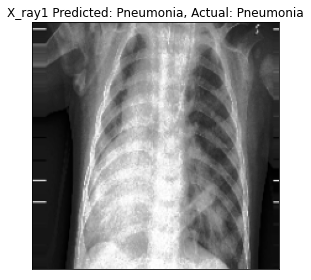

X_ray2
	Model prediction: [0.8244884  0.02388185 0.15162975]
	True label: Covid (0)
	Correct: True


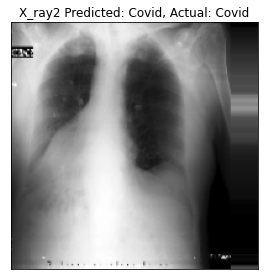

X_ray3
	Model prediction: [0.99134785 0.00532388 0.00332828]
	True label: Covid (0)
	Correct: True


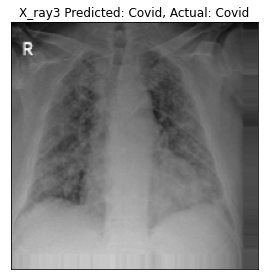

X_ray4
	Model prediction: [0.05280554 0.01941249 0.92778194]
	True label: Covid (0)
	Correct: False


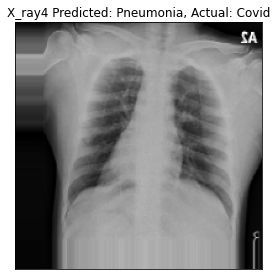

<Figure size 432x288 with 0 Axes>

In [37]:
#Ahora visualizaremos el funcionamiento del modelo
def clean_plot(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)
#Primero asignamos un valor a cada tipo de imagen y definimos una serie de variables
#para hacer pruebas con un conjunto de imágenes, en este caso cogemos solamente 5
class_names = {
        0: "Covid",
        1: "Normal",
        2: "Pneumonia"
    }
sample_batch_input, sample_labels = test_iter.next()
sample_batch_input = sample_batch_input[:5]
sample_labels = sample_labels[:5]

#Ahora realizamos las predicciones de esas 5 imágenes y mostramos: la imágen, la predicción,
#la veracidad de la predicción y la patología real del pulmón 
sample_predictions = final_model.predict(sample_batch_input)
for i, (image, prediction, label) in enumerate(zip(sample_batch_input, sample_predictions, sample_labels)):
    image_name = "X_ray{}".format(i)
    predicted_class = argmax(prediction).numpy()
    actual_class = argmax(label).numpy()
    print(image_name)
    print("\tModel prediction: {}".format(prediction))
    print("\tTrue label: {} ({})".format(class_names[actual_class], actual_class))
    print("\tCorrect:", predicted_class == actual_class)
    sample_image = image
    clean_plot(plt.imshow(
    sample_image[:, :, 0],
    cmap = "gray"
        ))
    plt.title(image_name + " Predicted: {}, Actual: {}".format(class_names[predicted_class], class_names[actual_class]))
    plt.tight_layout()
    plt.show()
    plt.clf()